In [1]:
import pandas as pd
import numpy as np
from torch import nn
from sklearn.preprocessing import PowerTransformer, StandardScaler
from torchviz import make_dot
from itertools import islice
import torch
import numpy
from sklearn.model_selection import train_test_split
import statistics as stats
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import hiddenlayer as hl
import graphviz
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

# Importing the data

In [2]:
def to_list(str):
    '''
    :param str: string representing a list of centipawn losses
    :return: list of integer centipawn losses
    '''
    string = str.replace('[','').replace(']','')
    ls = string.split(',')
    list = [float(i) for i in ls]

    return list

In [3]:
def black_process(evals, clocks, start_time):
    '''
    :param eval: list of integer centipawn losses
    :return: array of lists of [evaluation, centipawn loss]
    '''

    i = 0
    old_eval = 36
    old_clock = start_time
    res = []

    # iterating through centipawn losses
    for eval in evals:

        # subtracting the cpl for white's moves
        if i % 2 ==1:
            cpl = eval - old_eval
            clock_time = old_clock - clocks[i]
            res.append([cpl,clocks[i]])
            old_eval = eval
            old_clock = clock_time
            i += 1

        # adding the cpl for black's moves
        else:
            old_eval = eval
            old_clock -= clocks[i]
            i+=1

    return numpy.array(res)

In [4]:
def white_process(evals, clocks, start_time):
    '''
    :param eval: list of integer centipawn losses
    :return: array of lists of [evaluation, centipawn loss]
    '''

    i = 0
    old_eval = 36
    old_clock = start_time
    res = []

    # iterating through centipawn losses
    for eval in evals:

        # subtracting the cpl for white's moves
        if i % 2 ==0:
            cpl = old_eval - eval
            clock_time = old_clock - clocks[i]
            res.append([cpl, clock_time])
            old_eval = eval
            old_clock = clock_time
            i += 1

        # adding the cpl for black's moves
        else:
            old_eval = eval
            old_clock -= clocks[i]
            i+=1

    return numpy.array(res)

In [5]:
df1 = pd.read_csv('lichess/lichess_db_standard_rated_2022-12_1499999.csv')
df2 = pd.read_csv('lichess/lichess_db_standard_rated_2022-12_1500000_2500000.csv')
df3 = pd.read_csv('lichess/lichess_db_standard_rated_2022-12_2500000_3500000.csv')
df = pd.concat([df1,df2,df3])

In [6]:
# filtering out None or empty evaluations
df = df[ df['Eval'].apply(lambda x: isinstance(x, str))]
df = df[~df['Eval'].str.contains('None')]
df = df[df['Eval']!='']
df = df[df['Eval'] != '']
df = df[df['Eval'] != '[]']

In [7]:
df.value_counts('TimeControl')

TimeControl
600+0     20179
180+0     19016
180+2     16384
60+0      15746
300+0     13924
          ...  
3600+4        1
3600+8        1
420+11        1
420+14        1
960+6         1
Length: 373, dtype: int64

In [8]:
# picking a time control - I'm looking at 3 minute games
df = df[df["TimeControl"] == "180+0"]

In [9]:
# Filtering out * values
df = df[df['WhiteELO'] != '*']
df = df[df['BlackELO'] != '*']
df[['WhiteELO', 'BlackELO']] = df[['WhiteELO', 'BlackELO']] .astype(int)

# converting the evaluations and clock times to lists
df['Eval'] = df['Eval'].apply( to_list)
df['Clock'] = df['Clock'].apply(to_list)

# processing the evaluations and clock times into feature sequences
df['WhiteEval'] =df.apply(lambda x : white_process(x.Eval, x.Clock, 180), axis =1 )
df['BlackEval'] = df.apply(lambda x : black_process(x.Eval, x.Clock, 180), axis =1 )

In [10]:
# copying black's evaluations to the same column as white's, so we examine each game from both perspectives
df_flipped = df.copy()
df_flipped['WhiteEval'] = df_flipped['BlackEval']
df_flipped['WhiteELO'] = df_flipped['BlackELO']
df_flipped['White'] = df_flipped['Black']
df = pd.concat([df, df_flipped])

In [11]:
print(f"Evaluted games: {len(df['Eval'])}")

Evaluted games: 38032


# Regularizing Data

In [12]:
white_x = numpy.array(df['WhiteEval'])
white_length = numpy.array(df['WhiteEval'].apply(len))

black_x = numpy.array(df['WhiteEval'])
black_length = numpy.array(df['WhiteEval'].apply(len))

In [13]:
# creating and fitting a power transformer for black and white
wpt = StandardScaler()

white_y = numpy.concatenate(white_x) # concatenating so that the data has shape (samples,features)

wpt.fit(white_y)
white_transformed = wpt.transform(white_y)

bpt = PowerTransformer()
black_y = numpy.concatenate(black_x)
bpt.fit(black_y)
black_transformed = bpt.transform(black_y)

<AxesSubplot:>

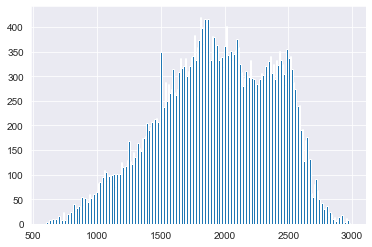

In [14]:
df['WhiteELO'].hist(bins = 200)

In [15]:
white_elo_arr = numpy.array(df['WhiteELO'])

In [16]:
#welopt = PowerTransformer(method = 'box-cox')
welopt = StandardScaler()
white_elo_arr = np.reshape(white_elo_arr, (len(white_elo_arr),1))
welopt.fit(white_elo_arr)
white_elo_transformed = welopt.transform(white_elo_arr)

(array([  73.,  200.,  453.,  794.,  971., 1297., 1793., 2385., 2903.,
        3345., 3846., 3540., 3306., 2944., 3129., 3239., 2448., 1017.,
         265.,   84.]),
 array([-2.96057703, -2.69513785, -2.42969867, -2.16425948, -1.8988203 ,
        -1.63338112, -1.36794194, -1.10250275, -0.83706357, -0.57162439,
        -0.30618521, -0.04074603,  0.22469316,  0.49013234,  0.75557152,
         1.0210107 ,  1.28644989,  1.55188907,  1.81732825,  2.08276743,
         2.34820661]),
 <BarContainer object of 20 artists>)

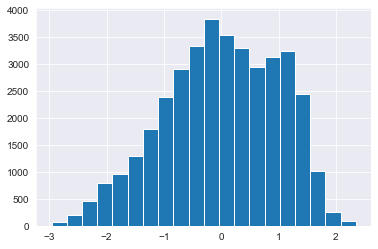

In [17]:
plt.hist(white_elo_transformed, bins =20)

In [18]:
white_transformed_array = [numpy.array(list(islice(iter(white_transformed), elem)))
        for elem in white_length]

black_transformed_array = [numpy.array(list(islice(iter(black_transformed), elem)))
        for elem in black_length]

# Splitting data into a training and test set

In [19]:
# converting evaluations and length to tensors
white_evals = [torch.tensor(i, dtype = torch.float32) for i in white_transformed_array]
white_lengths = [len(tensor) for tensor in white_evals]

black_evals = [torch.tensor(i, dtype = torch.float32) for i in black_transformed_array]
black_lengths = [len(tensor) for tensor in black_evals]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_25044\4220685215.py:2: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:77.)
  white_evals = [torch.tensor(i, dtype = torch.float32) for i in white_transformed_array]


In [20]:
def avg_cpl(white_processed):
    '''
    return the average centipawn loss from an evaluated game
    :param white_processed: list of lists of the form [evaluation, centipawn loss]
    :return: average centipawn loss (float)
    '''
    cpls = []
    for i in white_processed:
        cpls.append(i[1])
    if len(cpls) == 0:
        return float('NaN')
    else:
        return stats.mean(cpls)

In [21]:
df['White_avg_cpl'] = df['WhiteEval'].copy().apply( avg_cpl )

In [22]:
# Converting White and Black's ELOs to tensors
white_elo = [torch.tensor(i, dtype = torch.float32) for i in white_elo_transformed]



black_elo = numpy.array(df['BlackELO'])
black_elo = [torch.tensor(i, dtype = torch.float32) for i in black_elo]

average_cpl = np.array(df['White_avg_cpl'])

# splitting into train and test
white_eval_train, white_eval_test, black_eval_train, black_eval_test, black_train, black_test, white_train, white_test, average_cpl_train, average_cpl_test = train_test_split(white_evals, black_evals, black_elo, white_elo, average_cpl, test_size=0.2,random_state=0, shuffle = True)

In [23]:
# zipping together the features and targets
train_data_zip = list(zip(white_eval_train, white_train))
test_data_zip = list(zip(white_eval_test, white_test))

In [24]:
# black_elo = torch.stack(black_elo)
# white_elo = torch.stack(white_elo)

## Baseline model

In [25]:
average_cpl_train = np.reshape(average_cpl_train, (len(average_cpl_train),1))
average_cpl_test = np.reshape(average_cpl_test, (len(average_cpl_test),1))

In [26]:
white_train_elo = np.array([x.item() for x in white_train])
white_train_elo = np.reshape(white_train_elo, (len(white_train_elo),1 ))
white_train_elo_transformed = welopt.inverse_transform(white_train_elo)

white_test_elo = np.array([x.item() for x in white_test])
white_test_elo = np.reshape(white_test_elo, (len(white_test_elo),1 ))
white_test_elo_transformed = welopt.inverse_transform(white_test_elo)

In [27]:
# make a simple linear regression model.
regression = LinearRegression()
regression.fit(average_cpl_train,white_train_elo_transformed)
regression.score(average_cpl_test,white_test_elo)
y_pred = regression.predict(average_cpl_test)

In [28]:
mse_lin = mean_squared_error(white_test_elo_transformed, y_pred)

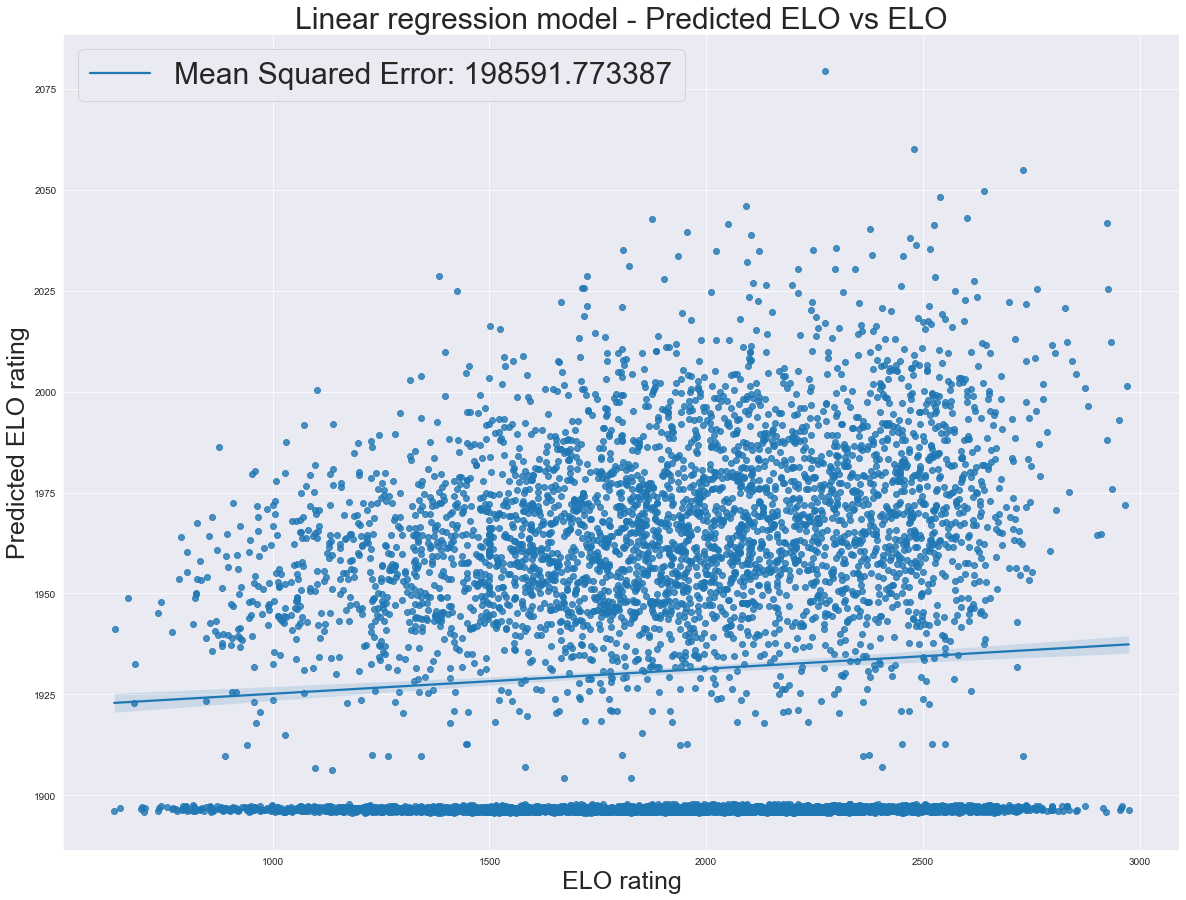

In [29]:
plt.figure(figsize = (20,15))
plt.title('Linear regression model - Predicted ELO vs ELO', fontsize = 30)
sns.regplot(x = white_test_elo_transformed, y = y_pred, line_kws = {'label':f'Mean Squared Error: {mse_lin:4f}'})
plt.xlabel('ELO rating', fontsize = 25)
plt.ylabel('Predicted ELO rating', fontsize = 25)
plt.legend(prop={'size': 30})
plt.savefig('images/NN_linreg_acc1.png')

# Creating the Neural Network

In [30]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, no_layers):
        super(MyLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.no_layers = no_layers
        torch.manual_seed(1)
        self.lstm = nn.LSTM(input_size, hidden_size, no_layers, batch_first = True, bias = True, dropout = 0.25)
        torch.manual_seed(2)
        self.fc = nn.Linear(hidden_size,1, bias = False)
        self.final = nn.Tanh()

    def forward(self, x):

        out, _ = self.lstm(x)
        output ,lengths = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first = True)


        out = [output[e, i-1,:].unsqueeze(0)for e, i in enumerate(lengths)]
        out = torch.cat(out, dim = 0)


        out = self.fc(out)
        out = self.final(out)
        out = out[:,0]

        return out

In [31]:
class MyCollator(object):
    '''
    Yields a batch from a list of Items
    Args:
    test : Set True when using with test data loader. Defaults to False
    percentile : Trim sequences by this percentile
    '''

    def __call__(self, batch):
        white_data = [item[0] for item in batch]
        target = [item[1] for item in batch]
        white_lens = [i.shape[0] for i in white_data]

        white_data = torch.nn.utils.rnn.pad_sequence(white_data, batch_first=True,padding_value = 0)
        white_evals_packed = torch.nn.utils.rnn.pack_padded_sequence(white_data,batch_first = True, lengths=white_lens,enforce_sorted=False)

        target = torch.tensor(target,dtype=torch.float32)
        return [white_evals_packed, target]

In [32]:
# defining parameters for the neural net
input_size = 2
hidden_size = 32
no_layers = 4
batch_size = 128

In [33]:
model = MyLSTM(input_size, hidden_size, no_layers)
collate = MyCollator()
print(model.parameters)

<bound method Module.parameters of MyLSTM(
  (lstm): LSTM(2, 32, num_layers=4, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=32, out_features=1, bias=False)
  (final): Tanh()
)>


# Training the model

In [34]:
writer = SummaryWriter('runs/h45l4-2')

In [35]:
data_loader = torch.utils.data.DataLoader(train_data_zip, batch_size=batch_size, shuffle=True ,collate_fn=collate)

In [36]:
learning_rate = .1

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [38]:
criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)

In [39]:
avg_losses = []
epochs = []
avg_loss = 0.1

for epoch in range(15):

    if (epoch+1) % 3 == 0:
        learning_rate /= 2
        optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)

    losses = []

    i = 0
    for white_evals, elo in data_loader:
        white_evals = white_evals.to(device)
        elo = elo.to(device)
        outputs = model(white_evals)
        loss = criterion(outputs,elo)

        # optimizing
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        i+=1

    change = stats.mean(losses)/avg_loss
    avg_loss = stats.mean(losses)

    # adding histograms to the summary writer
    for name, param in model.named_parameters():
        writer.add_histogram(name, np.array(param.detach().tolist()), epoch)

    # adding loss
    writer.add_scalar('Average loss',avg_loss, epoch)
    avg_losses.append(avg_loss)
    epochs.append(epoch)
    print(f'Epoch {epoch+1} step {i+1} - Learning Rate : {learning_rate}- Avg Loss: {avg_loss:3f} - Change in loss: {change}')


writer.close()

Epoch 1 step 239 - Learning Rate : 0.1- Avg Loss: 0.826696 - Change in loss: 8.266959568532574
Epoch 2 step 239 - Learning Rate : 0.1- Avg Loss: 0.805194 - Change in loss: 0.9739903820191117
Epoch 3 step 239 - Learning Rate : 0.05- Avg Loss: 0.808470 - Change in loss: 1.0040689982160689
Epoch 4 step 239 - Learning Rate : 0.05- Avg Loss: 0.793836 - Change in loss: 0.981899241946066
Epoch 5 step 239 - Learning Rate : 0.05- Avg Loss: 0.792402 - Change in loss: 0.9981926379144204
Epoch 6 step 239 - Learning Rate : 0.025- Avg Loss: 0.793307 - Change in loss: 1.00114273720042
Epoch 7 step 239 - Learning Rate : 0.025- Avg Loss: 0.789767 - Change in loss: 0.9955374410928254
Epoch 8 step 239 - Learning Rate : 0.025- Avg Loss: 0.789101 - Change in loss: 0.9991566684721911
Epoch 9 step 239 - Learning Rate : 0.0125- Avg Loss: 0.789269 - Change in loss: 1.0002130312335948
Epoch 10 step 239 - Learning Rate : 0.0125- Avg Loss: 0.788446 - Change in loss: 0.9989570003392609
Epoch 11 step 239 - Learning

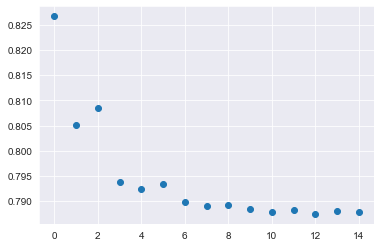

In [40]:
plt.scatter(epochs, avg_losses)

## Evaluating the model

In [41]:
model =model.eval()

In [42]:
model.to(device)

MyLSTM(
  (lstm): LSTM(2, 32, num_layers=4, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=32, out_features=1, bias=False)
  (final): Tanh()
)

In [43]:
test_data_loader = torch.utils.data.DataLoader(test_data_zip, batch_size=1, shuffle=False ,collate_fn=collate)

In [44]:
losses = []
outputs = []
elos = []
for evals, elo in test_data_loader:
    #print("evals",evals.shape)
    evals = evals.to(device)
    elo = elo.to(device)
    output = model(evals)
    outputs.append(output.item())
    elos.append(elo.item())
    loss = criterion(output,elo)
    #print(f'Model prediction : {output} \n ELO : {elo} \n MSE : {loss}')
    losses.append(loss.item())
print(f'Average loss : {stats.mean(losses)}')

Average loss : 0.7813614464580545


In [45]:
# preparing data to be inverse transformed
elos = np.array(elos)
elos = np.reshape(elos, (len(elos),1))

outputs = np.array(outputs)
outputs = np.reshape(outputs, (len(outputs),1))

In [46]:
# getting elos from the normalized values
elos = welopt.inverse_transform(elos)
outputs = welopt.inverse_transform(outputs)

In [47]:
mse_model = mean_squared_error(elos,outputs)

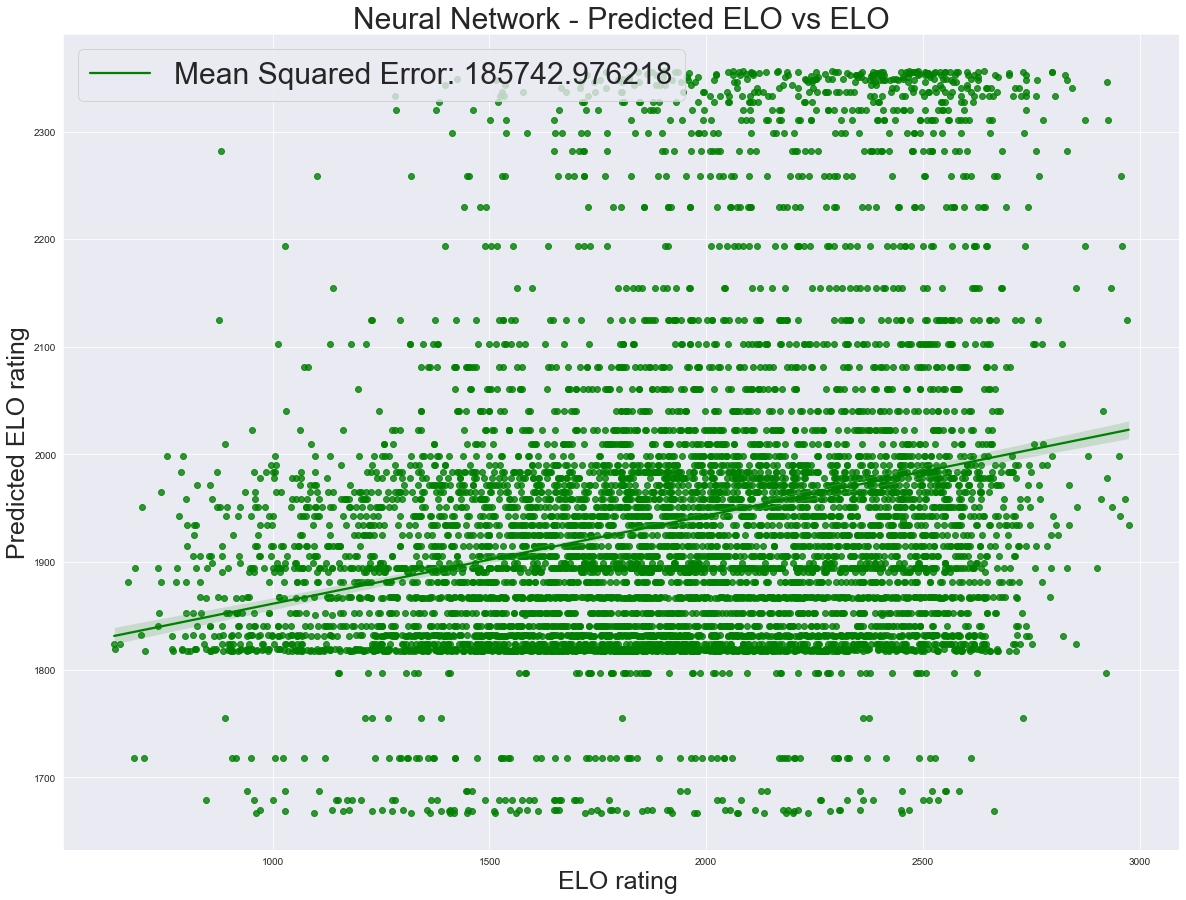

In [48]:
plt.figure(figsize = (20,15))
plt.title('Neural Network - Predicted ELO vs ELO', fontsize = 30)
sns.regplot(x = elos, y = outputs, color ='green', line_kws = {'label':f'Mean Squared Error: {mse_model:4f}'})
plt.xlabel('ELO rating ', fontsize = 25)
plt.ylabel('Predicted ELO rating', fontsize = 25)
plt.legend(prop={'size': 30})
plt.savefig('images/NN_model_acc1.png')

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

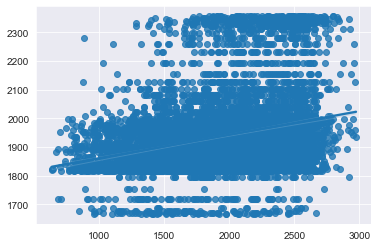

In [49]:
sns.regplot(elos,outputs)

# Plotting the neural net architecture

In [52]:
# plotting the neural net architecture
#dot = make_dot(output, params=model.params, show_attrs=False, show_saved=False)
#dot.render("rnn_torchviz3", format="pdf", engine= 'neato')